In [ ]:


import numpy as np
import pandas as pd



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/nlp-ass3/shakespear_dev (1).txt
/kaggle/input/nlp-ass3/shakespear_train (1).txt
/kaggle/input/a3-nlp/shakespear_dev_split.txt
/kaggle/input/a3-nlp/shakespear_train (1).txt
/kaggle/input/a3-nlp/shakespear_test_split.txt


100%|██████████| 308/308 [00:05<00:00, 54.57it/s]


Epoch 1/10 - Train Loss: 6.4599, Val Loss: 5.2890
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 54.77it/s]


Epoch 2/10 - Train Loss: 5.5843, Val Loss: 5.0687
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 54.10it/s]


Epoch 3/10 - Train Loss: 5.3210, Val Loss: 4.9551
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 53.58it/s]


Epoch 4/10 - Train Loss: 5.1423, Val Loss: 4.9006
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 53.37it/s]


Epoch 5/10 - Train Loss: 4.9961, Val Loss: 4.7941
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 52.60it/s]


Epoch 6/10 - Train Loss: 4.8624, Val Loss: 4.8457
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 53.16it/s]


Epoch 7/10 - Train Loss: 4.7431, Val Loss: 4.8119
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 53.71it/s]


Epoch 8/10 - Train Loss: 4.6214, Val Loss: 4.8221
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 53.91it/s]


Epoch 9/10 - Train Loss: 4.5075, Val Loss: 4.7912
Generated sample: <START> <START>


100%|██████████| 308/308 [00:05<00:00, 54.35it/s]


Epoch 10/10 - Train Loss: 4.3922, Val Loss: 4.8186
Generated sample: <START> <START>


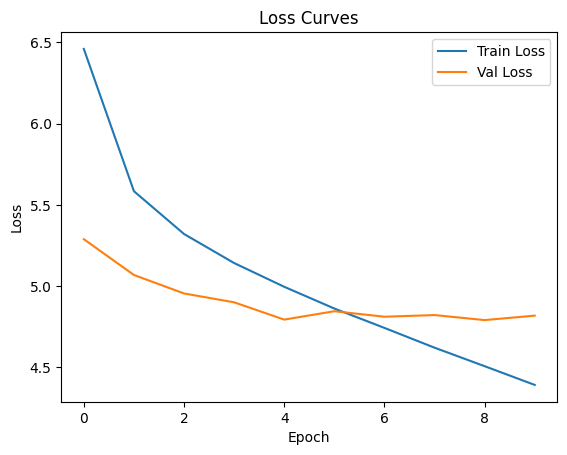

/tmp/ipykernel_31/2694880655.py:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))



--- Generated Samples ---
<START> Master , master , look about you : who goes there , ha ?
<START> : Peace , !
<START> it is the of my love .
<START> , stand by a while .
<START> : A proper stripling and an amorous !

Test Perplexity: 93.95


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Device and Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 64
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 512
NUM_LAYERS = 4
DROPOUT = 0.1
BATCH_SIZE = 32
EPOCHS = 10

# Special Tokens
SPECIAL_TOKENS = ["<PAD>", "<START>", "<STOP>"]

# Utility Functions

def flat(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def pad_to_length(tokens, max_len, tokenizer):
    tokens = tokens[:max_len]
    pad_len = max_len - len(tokens)
    return tokens + [tokenizer["<PAD>"]]*pad_len

def tokenize(sentence, tokenizer, pad_to_len=None, include_stop=True):
    tokens = sentence.strip().split()
    if include_stop:
        tokens.append("<STOP>")
    tokens = ["<START>"] + tokens
    token_ids = [tokenizer.get(tok, tokenizer["<PAD>"]) for tok in tokens]
    if pad_to_len:
        token_ids = pad_to_length(token_ids, pad_to_len, tokenizer)
    return token_ids

def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    out = []
    for t in tokens:
        word = tokenizer_inv.get(t, "<UNK>")
        if omit_pad and word == "<PAD>":
            continue
        if end_at_stop and word == "<STOP>":
            break
        out.append(word)
    return " ".join(out)

# Dataset Preparation
class TextDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = tokenize(self.data[idx], self.tokenizer, pad_to_len=MAX_LEN)
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)
        return x, y

def load_and_preprocess_data():
    with open("/kaggle/input/a3-nlp/shakespear_train (1).txt", "r") as f:
        lines_train = f.readlines()
    with open("/kaggle/input/a3-nlp/shakespear_test_split.txt", "r") as f:
        lines_val = f.readlines()

    tokens_train = [line.strip().split() for line in lines_train]
    vocab = list(set(flat(tokens_train))) + SPECIAL_TOKENS
    tokenizer = {w: i for i, w in enumerate(sorted(vocab))}
    tokenizer_inv = {i: w for w, i in tokenizer.items()}

    train_dataset = TextDataset(lines_train, tokenizer)
    val_dataset = TextDataset(lines_val, tokenizer)

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

# Model Components
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        B, T, C = x.size()
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(B, T, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = (attn_weights @ v).transpose(1, 2).reshape(B, T, C)
        return self.out_proj(attn_output)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.ln2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.attn(self.ln1(x), mask))
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x

class TransformerLM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, EMBED_DIM)
        self.pos_emb = nn.Embedding(MAX_LEN, EMBED_DIM)
        self.blocks = nn.ModuleList([
            TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT) for _ in range(NUM_LAYERS)
        ])
        self.ln = nn.LayerNorm(EMBED_DIM)
        self.fc = nn.Linear(EMBED_DIM, vocab_size)

    def forward(self, x):
        B, T = x.size()
        pos = torch.arange(0, T, device=x.device).unsqueeze(0)
        x = self.token_emb(x) + self.pos_emb(pos)
        mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        for block in self.blocks:
            x = block(x, mask)
        x = self.ln(x)
        logits = self.fc(x)
        return logits

# Perplexity Evaluation
@torch.no_grad()
def evaluate_perplexity(model, data, tokenizer):
    model.eval()
    losses = []
    for sentence in data:
        tokens = torch.tensor(tokenize(sentence, tokenizer, pad_to_len=MAX_LEN), dtype=torch.long).to(DEVICE)
        x, y = tokens[:-1].unsqueeze(0), tokens[1:].unsqueeze(0)
        logits = model(x)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y[..., None])[..., 0]
        #not_pad = y != tokenizer["<PAD>"]
        not_pad = y[0] != tokenizer["<PAD>"]
        loss = -y_log_probs[0][not_pad].mean().item()

        losses.append(loss)
    return math.exp(sum(losses)/len(losses))

# Text Generation
@torch.no_grad()
def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=20, temperature=1.0):
    model.eval()
    tokens = tokenize(context, tokenizer, pad_to_len=None)
    for _ in range(gen_tokens):
        x = torch.tensor([pad_to_length(tokens, MAX_LEN, tokenizer)], dtype=torch.long).to(DEVICE)
        logits = model(x)[0, len(tokens)-1]
        probs = F.softmax(logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, 1).item()
        tokens.append(next_token)
        if tokenizer_inv[next_token] == "<STOP>":
            break
    return decode(tokens, tokenizer_inv)

# Training Loop

def train_model(model, train_loader, val_loader, tokenizer, tokenizer_inv):
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"])
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
                val_loss += loss.item()
            val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
        print("Generated sample:", generate_text(model, tokenizer, tokenizer_inv))

    # Plot losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("loss_plot.png")
    plt.show()

    torch.save(model.state_dict(), "transformer_lm.pt")
    return model

# Inference Function
@torch.no_grad()
def inference(model_path, test_file, tokenizer, tokenizer_inv):
    model = TransformerLM(vocab_size=len(tokenizer)).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    with open(test_file, "r") as f:
        test_lines = f.readlines()
    ppl = evaluate_perplexity(model, test_lines, tokenizer)
    generated = [generate_text(model, tokenizer, tokenizer_inv, line.strip(), gen_tokens=20) for line in test_lines[:5]]
    return generated, ppl

# Run Everything
if __name__ == "__main__":
    train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = TransformerLM(vocab_size=len(tokenizer)).to(DEVICE)
    trained_model = train_model(model, train_loader, val_loader, tokenizer, tokenizer_inv)

    # Final inference
    generated_texts, test_ppl = inference("transformer_lm.pt", "/kaggle/input/a3-nlp/shakespear_test_split.txt", tokenizer, tokenizer_inv)
    print("\n--- Generated Samples ---")
    for t in generated_texts:
        print(t)
    print(f"\nTest Perplexity: {test_ppl:.2f}")
